# **LSTM Prediction model**
This notebook will be dividided by sections as follows:\
-Data load\
-Data Preparation\
-Build LSTM\
-Fit LSTM\
-Forecast Predictions\

### **Data Loading**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random


confirmed_cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
confirmed_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
confirmed_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [2]:
confirmed_cases

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,23546,24102,24766,25527,26310,26874,27532,27878,28424,28833
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,1416,1464,1521,1590,1672,1722,1788,1838,1891,1962
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,10698,10810,10919,11031,11147,11268,11385,11504,11631,11771
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,853,853,853,853,854,854,855,855,855,855
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,130,138,140,142,148,155,166,172,176,183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,639,659,661,662,671,683,688,693,698,698
262,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,632,705,728,844,885,902,909,919,922,941
263,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,...,163,176,176,176,197,197,210,210,247,247
264,NaN,Tajikistan,38.861034,71.276093,0,0,0,0,0,0,...,4902,4971,5035,5097,5160,5221,5279,5338,5399,5457


In [3]:
class DataNew():
    def __init__(self,country):
        self.country = country
        self.confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
        self.deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
        self.recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
        self.PreparaData()

    def PreparaData(self):
        timesteps = []
        total_infetados = []
        total_Days = []
        total_Deaths = []
        total_Recovered = []
        self.new_dataset = pd.DataFrame()
        Ground_Zero = dt.strptime('12/31/19','%m/%d/%y')
        for cols in self.confirmed.columns:
            timesteps.append(cols)
            total_infetados.append(self.confirmed[cols].sum())
            current_date = dt.strptime(cols,'%m/%d/%y')
            days_Gone = current_date - Ground_Zero
            total_Days.append(int(days_Gone.days))
        for cols in self.deaths.columns:
            total_Deaths.append(self.deaths[cols].sum())
        for cols in self.recovered.columns:
            total_Recovered.append(self.recovered[cols].sum())
        self.new_dataset['Total_Cases'] = total_infetados
        self.new_dataset['Total_Recovered'] = total_Recovered
        self.new_dataset['Total_Deaths'] = total_Deaths
        self.new_dataset['Days_Gone'] = total_Days
        pd.DataFrame.to_csv(self.new_dataset,'Dados/new_dataset.csv',index=False)
        

### **Data Preparation**
To prepare the data to feed the LSTM network, eah row is correspondant to a day and each collumn is a total for a specific country as follows:\
-Total_Cases\
-Total_Deaths\
-Total_Recoveries\
-Days_Gone

In [4]:
class Data():
    def __init__(self,country):
        self.country = country
        self.confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
        self.deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
        self.recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
        if(country == "World Wide"):
            self.PreparaDataGlobal()
        else:
            self.PreparaData()

    def PreparaData(self):
        confirmedPortugal = self.confirmed[ self.confirmed['Country/Region'] != self.country].index
        self.confirmed.drop(confirmedPortugal , inplace=True)
        deathsPortugal = self.deaths[ self.deaths['Country/Region'] != self.country].index
        self.deaths.drop(deathsPortugal , inplace=True)
        recoveredPortugal = self.recovered[ self.recovered['Country/Region'] != self.country].index
        self.recovered.drop(recoveredPortugal , inplace=True)
        self.confirmed = self.confirmed.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.deaths = self.deaths.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.recovered = self.recovered.drop(columns=['Province/State','Country/Region','Lat','Long'])
        timesteps = []
        total_infetados = []
        total_Days = []
        total_Deaths = []
        total_Recovered = []
        daily_deaths=[]
        daily_cases=[]
        day_of_week=[]
        self.new_dataset = pd.DataFrame()
        Ground_Zero = dt.strptime('12/31/19','%m/%d/%y')
        for cols in self.confirmed.columns:
            timesteps.append(cols)
            total_infetados.append(self.confirmed[cols].sum())
            current_date = dt.strptime(cols,'%m/%d/%y')
            day_of_week.append(current_date.weekday())
            days_Gone = current_date - Ground_Zero
            total_Days.append(int(days_Gone.days))
            daily_cases.append(self.confirmed[cols].sum()-sum(daily_cases))
        for cols in self.deaths.columns:
            total_Deaths.append(self.deaths[cols].sum())
            daily_deaths.append(self.deaths[cols].sum()-sum(daily_deaths))
        for cols in self.recovered.columns:
            total_Recovered.append(self.recovered[cols].sum())
        self.new_dataset['Total_Cases'] = total_infetados
        self.new_dataset['Daily_Cases'] = daily_cases
        self.new_dataset['WeekDay'] = day_of_week
        self.new_dataset['Daily_Deaths'] = daily_deaths
        self.new_dataset['Total_Recovered'] = total_Recovered
        self.new_dataset['Total_Deaths'] = total_Deaths
        self.new_dataset['Days_Gone'] = total_Days
        pd.DataFrame.to_csv(self.new_dataset,'Dados/new_dataset.csv',index=False)
    def PreparaDataGlobal(self):
        self.confirmed = self.confirmed.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.deaths = self.deaths.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.recovered = self.recovered.drop(columns=['Province/State','Country/Region','Lat','Long'])
        timesteps = []
        total_infetados = []
        total_Days = []
        total_Deaths = []
        total_Recovered = []
        self.new_dataset = pd.DataFrame()
        Ground_Zero = dt.strptime('12/31/19','%m/%d/%y')
        for cols in self.confirmed.columns:
            timesteps.append(cols)
            total_infetados.append(self.confirmed[cols].sum())
            current_date = dt.strptime(cols,'%m/%d/%y')
            days_Gone = current_date - Ground_Zero
            total_Days.append(int(days_Gone.days))
        for cols in self.deaths.columns:
            total_Deaths.append(self.deaths[cols].sum())
        for cols in self.recovered.columns:
            total_Recovered.append(self.recovered[cols].sum())
        self.new_dataset['Total_Cases'] = total_infetados
        self.new_dataset['Total_Recovered'] = total_Recovered
        self.new_dataset['Total_Deaths'] = total_Deaths
        self.new_dataset['Days_Gone'] = total_Days
        pd.DataFrame.to_csv(self.new_dataset,'Dados/new_dataset.csv',index=False)



### **Feeding LSTM**
To feed the LSTM, we give 15 timesteps wich correspond to 15 individual days.\
The model uses a single column,Total_Cases, to predict the total cases for each country.\
The Model receives all data normalized in range [-1,1], this maximizes perfomance

In [11]:
class LSTM():
    def __init__(self):
        self.df = pd.read_csv('Dados/new_dataset.csv')
        self.NormalizeData()
        self.timesteps = 15
        self.nr_parametos=2
        self.PrepareData(self.timesteps)
        self.Build(self.timesteps,self.nr_parametos)
        self.Fit()
    def NormalizeData(self):
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        self.normalized = self.scaler.fit_transform(self.df)
        #print(self.normalized)
        
    def Denormalize(self,dfNormalized):
        pass
    
    
    def PrepareData(self,timesteps):
        i = 0
        self.X = []
        self.Y = []
        while i in range(len(self.normalized - timesteps)):
            input_index = i + timesteps
            label_index = input_index + 1
            if(label_index < len(self.normalized)):
                self.X.append(self.normalized[i:input_index,1:3])
                self.Y.append(self.normalized[input_index:label_index,1])
            i+=1
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)
        self.X_test = self.X[-10:]
        self.Y_test = self.Y[-10:]
        self.X = self.X[:-10]
        self.Y = self.Y[:-10]
        #print(self.X)
        X = self.X
        #print(self.Y)
        Y=self.Y
    
    '''
    def Prepare_Data(self,dataset):
        x = dataset.drop(columns=['Total_Deaths'])
        self.X = x.to_numpy()
        y = dataset['Total_Deaths']
        self.Y = y.to_numpy()
        self.Y = self.Y.astype(float)
    '''
    def Build(self,janela,nmr_parametros):
        self.model = keras.Sequential()
        self.model.add(keras.layers.LSTM(32, input_shape=(janela, nmr_parametros), return_sequences=True))
        self.model.add(keras.layers.LSTM(64, return_sequences=True))
        self.model.add(keras.layers.LSTM(128, return_sequences=False))
        self.model.add(keras.layers.Dropout(0.2))
        self.model.add(keras.layers.Dense(32, activation="relu", kernel_initializer="uniform"))
        self.model.add(keras.layers.Dropout(0.2))
        self.model.add(keras.layers.Dense(1, activation="linear"))
    
    def BuildDeaths(self,janela,nmr_parametros):
        self.modelDeaths = keras.Sequential()
        self.modelDeaths.add(keras.layers.LSTM(32, input_shape=(janela, nmr_parametros), return_sequences=True))
        self.modelDeaths.add(keras.layers.LSTM(64, return_sequences=True))
        self.modelDeaths.add(keras.layers.LSTM(128, return_sequences=False))
        self.modelDeaths.add(keras.layers.Dropout(0.2))
        self.modelDeaths.add(keras.layers.Dense(32, activation="relu", kernel_initializer="uniform"))
        self.modelDeaths.add(keras.layers.Dropout(0.2))
        self.modelDeaths.add(keras.layers.Dense(1, activation="linear"))
        
    def RMSE(self,y_true,y_pred):
        return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))

    def Fit(self):
        self.model.compile(loss=self.RMSE,optimizer=keras.optimizers.Adam(),metrics=['mae',self.RMSE])
        try:
            self.model.load_weights("model.h5")
        except:
            print('Model not found')
        self.history = self.model.fit(x=self.X,y=self.Y,epochs=400,batch_size = 7,validation_split=0.05,shuffle=False)
        #self.model.save_weights("model.h5")
    def PredictTest(self,data):
        result = self.model.predict(data,verbose=True)
        print(result)
        results = []
        for res in result:
            Denormalized = np.ndarray((1,7))
            Denormalized[0][0] = -1
            Denormalized[0][1] = res
            Denormalized[0][2] = -1
            Denormalized[0][3] = -1
            Denormalized[0][4] = -1
            Denormalized[0][5] = -1
            Denormalized[0][6] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            results.append(value[0][1])
        return results
    
    def Predict(self,data):
        result = self.model.predict(data,verbose=True)
        return result
        
    def forecast(self):
        timesteps= self.timesteps
        multisteps=50
        data_norm=pd.DataFrame(self.normalized)
        input_seq=data_norm[-timesteps:].values
        inp=input_seq[:,1:3]
        
        
        predictions=list()
        
        inp = np.array(inp).astype('float32')
        #print(inp)
        for step in range(1, multisteps+1):
            
            inp=inp.reshape(1,timesteps,2)
            
            taxa_Erro = random.uniform(-0.005,0.005 )

            yhat=self.Predict(inp) + taxa_Erro
            
            Denormalized = np.ndarray((1,7))
            Denormalized[0][0] = -1
            Denormalized[0][1] = yhat
            Denormalized[0][2] = inp[0][inp.shape[1]-1][1]
            Denormalized[0][3] = -1
            Denormalized[0][4] = -1
            Denormalized[0][5] = -1
            Denormalized[0][6] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            predictions.append(value[0][1])
            #predictions.append(yhat[0][0])
            newCase = np.array((float(yhat),inp[0][inp.shape[1]-7][1]))  #
            inp = np.append(inp, newCase)
            inp = np.reshape(inp,(-1,2))
            inp=inp[-timesteps:,:]
            #print(inp)
        self.PredictionGraph(predictions)
    def PredictionGraph(self,prediction):
        new_pred = []
        verificador = 0
        for pred in prediction:
            if(verificador == 0):  
                new_pred.append(self.df['Total_Cases'].iloc[-1] + int(pred))
                verificador = 1
            else:
                new_pred.append(new_pred[-1] + int(pred))
        fig, ax = plt.subplots(figsize=(20, 10))
        fig.suptitle('Previsao Casos ', fontweight='bold',fontsize=30, color='#0c3c6e')
        plt.xlabel('Dia', fontsize=20)
        plt.ylabel('Previsão', fontsize=20)
        ax.plot(np.arange(len(self.df)),(self.df['Total_Cases']), label='Days Gone with real data')
        ax.plot(np.arange(len(self.df),len(self.df) + len(new_pred)),(new_pred), label='50 days LSTM prediction')
        ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,fontsize='15')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
              
        ax.grid()
        #fig.savefig('static/lstm.png')

    def barplot(self,predictions):
        teste = []
        for res in self.Y_test.flatten():
            Denormalized = np.ndarray((1,7))
            Denormalized[0][0] = -1
            Denormalized[0][1] = res
            Denormalized[0][2] = -1
            Denormalized[0][3] = -1
            Denormalized[0][4] = -1
            Denormalized[0][5] = -1
            Denormalized[0][6] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            teste.append(value[0][1])
        
        df = pd.DataFrame({'Actual': teste, 'Predicted': np.asarray(predictions).flatten()})

        df1 = df.head(25)
        df1.plot(kind='bar',figsize=(16,10))
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
        plt.show()
        
    def PlotLoss(self):
        fig, ax = plt.subplots(figsize=(20, 10))
        print(self.model.history.history.keys())
        plt.plot(self.model.history.history['loss'])
        plt.plot(self.model.history.history['val_loss'])
        plt.title('loss vs val_loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['loss'], loc='upper left')
        plt.show()
        

In [17]:
country = "Spain"
data = Data(country)


In [18]:
data.new_dataset

,Total_Cases,Daily_Cases,WeekDay,Daily_Deaths,Total_Recovered,Total_Deaths,Days_Gone
0,0,0,2,0,0,0,22
1,0,0,3,0,0,0,23
2,0,0,4,0,0,0,24
3,0,0,5,0,0,0,25
4,0,0,6,0,0,0,26
...,...,...,...,...,...,...,...
147,244683,355,2,0,150376,27136,169
148,245268,585,3,0,150376,27136,170
149,245575,307,4,1179,150376,28315,171
150,245938,363,5,7,150376,28322,172


### **Predictions**
To forecast the future, we feed the last 15 days to predict the next day, then the day predicted gets added to the dataset and the next day is predicted using the last 15 correspondant days.\
After 15 predictions, the network is using its own predictions, this may cause the error to increase but this way we can calculate when the numbers will stagnate in each country.\
The graph shown bellow show the predicted numbers for the US, to predict other countries just change the "country" variable in the cell above.

Model not found
Train on 119 samples, validate on 7 samples
Epoch 1/400
119/119 [==============================] - 7s 60ms/sample - loss: 0.2290 - mae: 0.2033 - RMSE: 0.2290 - val_loss: 0.0654 - val_mae: 0.0652 - val_RMSE: 0.0654
Epoch 2/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.2405 - mae: 0.2190 - RMSE: 0.2405 - val_loss: 0.0059 - val_mae: 0.0039 - val_RMSE: 0.0059
Epoch 3/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.2006 - mae: 0.1729 - RMSE: 0.2006 - val_loss: 0.0521 - val_mae: 0.0515 - val_RMSE: 0.0521
Epoch 4/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.1706 - mae: 0.1412 - RMSE: 0.1706 - val_loss: 0.0099 - val_mae: 0.0091 - val_RMSE: 0.0099
Epoch 5/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.1943 - mae: 0.1685 - RMSE: 0.1943 - val_loss: 0.0346 - val_mae: 0.0344 - val_RMSE: 0.0346
Epoch 6/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.1676 - mae: 0.1

Epoch 49/400
119/119 [==============================] - 0s 3ms/sample - loss: 0.1357 - mae: 0.1068 - RMSE: 0.1357 - val_loss: 0.0175 - val_mae: 0.0158 - val_RMSE: 0.0175
Epoch 50/400
119/119 [==============================] - 0s 4ms/sample - loss: 0.1125 - mae: 0.0844 - RMSE: 0.1125 - val_loss: 0.0178 - val_mae: 0.0133 - val_RMSE: 0.0178
Epoch 51/400
119/119 [==============================] - 0s 4ms/sample - loss: 0.1499 - mae: 0.1222 - RMSE: 0.1499 - val_loss: 0.0203 - val_mae: 0.0187 - val_RMSE: 0.0203
Epoch 52/400
119/119 [==============================] - 0s 3ms/sample - loss: 0.1143 - mae: 0.0844 - RMSE: 0.1143 - val_loss: 0.0159 - val_mae: 0.0115 - val_RMSE: 0.0159
Epoch 53/400
119/119 [==============================] - 0s 3ms/sample - loss: 0.1169 - mae: 0.0873 - RMSE: 0.1169 - val_loss: 0.0248 - val_mae: 0.0242 - val_RMSE: 0.0248
Epoch 54/400
119/119 [==============================] - 0s 3ms/sample - loss: 0.1066 - mae: 0.0786 - RMSE: 0.1066 - val_loss: 0.0181 - val_mae: 0.0144

Epoch 97/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.1213 - mae: 0.0887 - RMSE: 0.1213 - val_loss: 0.0203 - val_mae: 0.0195 - val_RMSE: 0.0203
Epoch 98/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.1121 - mae: 0.0857 - RMSE: 0.1121 - val_loss: 0.0102 - val_mae: 0.0077 - val_RMSE: 0.0102
Epoch 99/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.1446 - mae: 0.1188 - RMSE: 0.1446 - val_loss: 0.0213 - val_mae: 0.0207 - val_RMSE: 0.0213
Epoch 100/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.1117 - mae: 0.0816 - RMSE: 0.1117 - val_loss: 0.0142 - val_mae: 0.0125 - val_RMSE: 0.0142
Epoch 101/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.1108 - mae: 0.0812 - RMSE: 0.1108 - val_loss: 0.0195 - val_mae: 0.0169 - val_RMSE: 0.0195
Epoch 102/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.1277 - mae: 0.0967 - RMSE: 0.1277 - val_loss: 0.0147 - val_mae: 0.0

Epoch 145/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.1231 - mae: 0.0912 - RMSE: 0.1231 - val_loss: 0.0092 - val_mae: 0.0074 - val_RMSE: 0.0092
Epoch 146/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.1076 - mae: 0.0776 - RMSE: 0.1076 - val_loss: 0.0059 - val_mae: 0.0049 - val_RMSE: 0.0059
Epoch 147/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.1035 - mae: 0.0711 - RMSE: 0.1035 - val_loss: 0.0075 - val_mae: 0.0056 - val_RMSE: 0.0075
Epoch 148/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.1125 - mae: 0.0774 - RMSE: 0.1125 - val_loss: 0.0080 - val_mae: 0.0057 - val_RMSE: 0.0080
Epoch 149/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.1253 - mae: 0.0955 - RMSE: 0.1253 - val_loss: 0.0193 - val_mae: 0.0187 - val_RMSE: 0.0193
Epoch 150/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.1073 - mae: 0.0766 - RMSE: 0.1073 - val_loss: 0.0094 - val_mae: 

Epoch 193/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.1032 - mae: 0.0722 - RMSE: 0.1032 - val_loss: 0.0133 - val_mae: 0.0103 - val_RMSE: 0.0133
Epoch 194/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.1112 - mae: 0.0782 - RMSE: 0.1112 - val_loss: 0.0072 - val_mae: 0.0057 - val_RMSE: 0.0072
Epoch 195/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.0980 - mae: 0.0687 - RMSE: 0.0980 - val_loss: 0.0088 - val_mae: 0.0076 - val_RMSE: 0.0088
Epoch 196/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.1110 - mae: 0.0772 - RMSE: 0.1110 - val_loss: 0.0118 - val_mae: 0.0093 - val_RMSE: 0.0118
Epoch 197/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.1011 - mae: 0.0721 - RMSE: 0.1011 - val_loss: 0.0078 - val_mae: 0.0061 - val_RMSE: 0.0078
Epoch 198/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.1097 - mae: 0.0804 - RMSE: 0.1097 - val_loss: 0.0075 - val_mae: 

Epoch 241/400
119/119 [==============================] - 0s 3ms/sample - loss: 0.0923 - mae: 0.0645 - RMSE: 0.0923 - val_loss: 0.0110 - val_mae: 0.0090 - val_RMSE: 0.0110
Epoch 242/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.0935 - mae: 0.0658 - RMSE: 0.0935 - val_loss: 0.0200 - val_mae: 0.0179 - val_RMSE: 0.0200
Epoch 243/400
119/119 [==============================] - 0s 3ms/sample - loss: 0.0905 - mae: 0.0645 - RMSE: 0.0905 - val_loss: 0.0140 - val_mae: 0.0123 - val_RMSE: 0.0140
Epoch 244/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.0984 - mae: 0.0714 - RMSE: 0.0984 - val_loss: 0.0103 - val_mae: 0.0089 - val_RMSE: 0.0103
Epoch 245/400
119/119 [==============================] - 0s 3ms/sample - loss: 0.0898 - mae: 0.0647 - RMSE: 0.0898 - val_loss: 0.0135 - val_mae: 0.0108 - val_RMSE: 0.0135
Epoch 246/400
119/119 [==============================] - 0s 3ms/sample - loss: 0.0905 - mae: 0.0660 - RMSE: 0.0905 - val_loss: 0.0109 - val_mae: 

Epoch 289/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.0842 - mae: 0.0596 - RMSE: 0.0842 - val_loss: 0.0146 - val_mae: 0.0120 - val_RMSE: 0.0146
Epoch 290/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.0837 - mae: 0.0599 - RMSE: 0.0837 - val_loss: 0.0160 - val_mae: 0.0122 - val_RMSE: 0.0160
Epoch 291/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.0810 - mae: 0.0597 - RMSE: 0.0810 - val_loss: 0.0172 - val_mae: 0.0142 - val_RMSE: 0.0172
Epoch 292/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.0959 - mae: 0.0719 - RMSE: 0.0959 - val_loss: 0.0130 - val_mae: 0.0099 - val_RMSE: 0.0130
Epoch 293/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.0897 - mae: 0.0623 - RMSE: 0.0897 - val_loss: 0.0131 - val_mae: 0.0105 - val_RMSE: 0.0131
Epoch 294/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.0877 - mae: 0.0640 - RMSE: 0.0877 - val_loss: 0.0155 - val_mae: 

Epoch 337/400
119/119 [==============================] - 0s 3ms/sample - loss: 0.0549 - mae: 0.0426 - RMSE: 0.0549 - val_loss: 0.0167 - val_mae: 0.0140 - val_RMSE: 0.0167
Epoch 338/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.0749 - mae: 0.0607 - RMSE: 0.0749 - val_loss: 0.0111 - val_mae: 0.0096 - val_RMSE: 0.0111
Epoch 339/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.1019 - mae: 0.0770 - RMSE: 0.1019 - val_loss: 0.0136 - val_mae: 0.0128 - val_RMSE: 0.0136
Epoch 340/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.0841 - mae: 0.0600 - RMSE: 0.0841 - val_loss: 0.0250 - val_mae: 0.0230 - val_RMSE: 0.0250
Epoch 341/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.0913 - mae: 0.0641 - RMSE: 0.0913 - val_loss: 0.0165 - val_mae: 0.0141 - val_RMSE: 0.0165
Epoch 342/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.0914 - mae: 0.0690 - RMSE: 0.0914 - val_loss: 0.0426 - val_mae: 

Epoch 385/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.0738 - mae: 0.0530 - RMSE: 0.0738 - val_loss: 0.0267 - val_mae: 0.0194 - val_RMSE: 0.0267
Epoch 386/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.0585 - mae: 0.0444 - RMSE: 0.0585 - val_loss: 0.0191 - val_mae: 0.0173 - val_RMSE: 0.0191
Epoch 387/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.0608 - mae: 0.0479 - RMSE: 0.0608 - val_loss: 0.0292 - val_mae: 0.0212 - val_RMSE: 0.0292
Epoch 388/400
119/119 [==============================] - 0s 3ms/sample - loss: 0.0672 - mae: 0.0495 - RMSE: 0.0672 - val_loss: 0.0168 - val_mae: 0.0156 - val_RMSE: 0.0168
Epoch 389/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.0589 - mae: 0.0450 - RMSE: 0.0589 - val_loss: 0.0241 - val_mae: 0.0193 - val_RMSE: 0.0241
Epoch 390/400
119/119 [==============================] - 0s 2ms/sample - loss: 0.0596 - mae: 0.0452 - RMSE: 0.0596 - val_loss: 0.0181 - val_mae: 

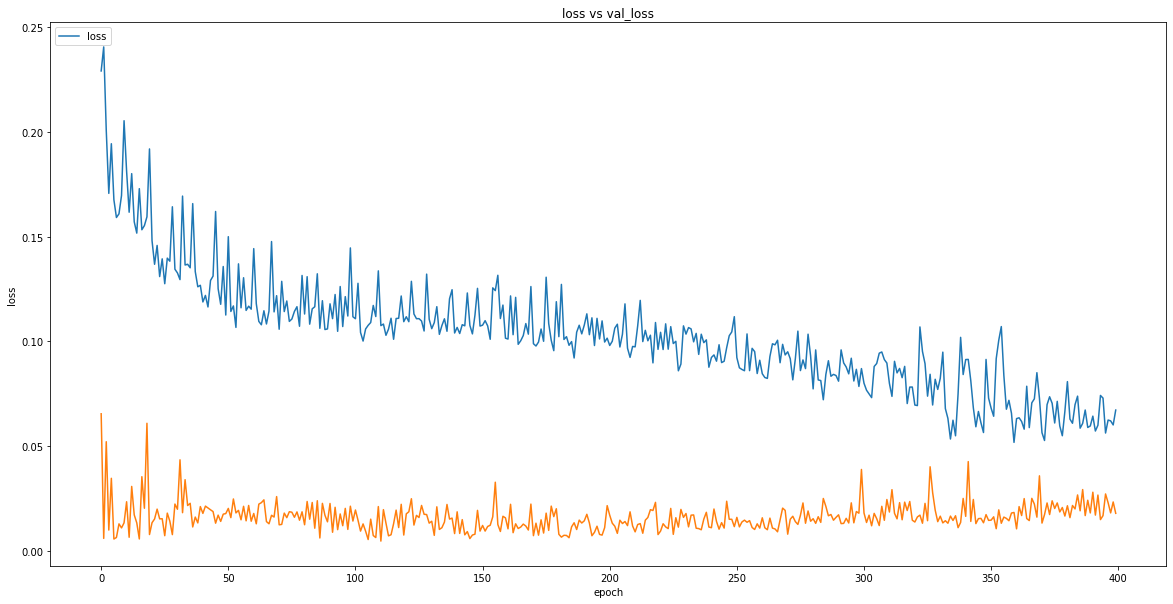

10/10 [==============================] - 1s 122ms/sample
[[0.04902428]
 [0.05992763]
 [0.03540355]
 [0.02835048]
 [0.03181485]
 [0.03707236]
 [0.03104083]
 [0.04875148]
 [0.06523058]
 [0.03768037]]


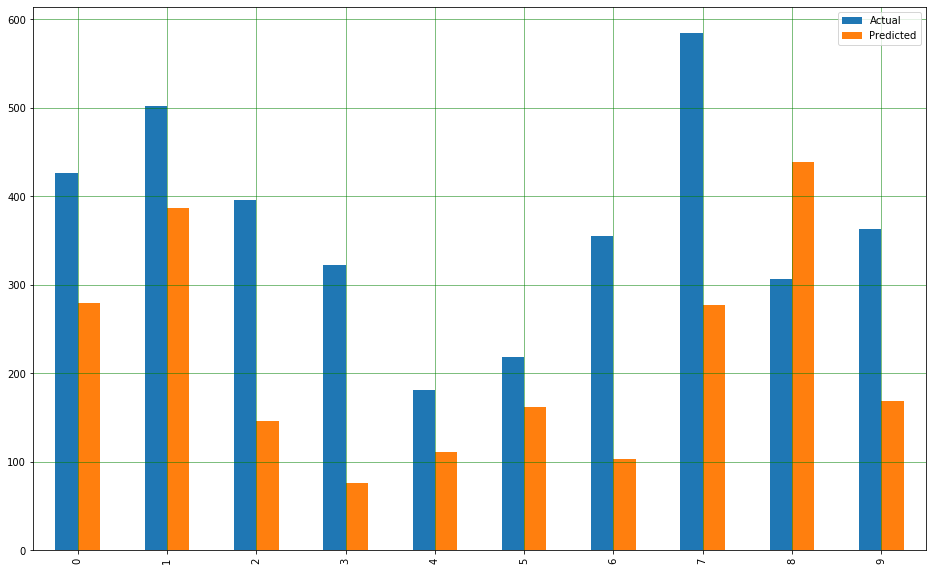

In [19]:
lstm = LSTM()
lstm.PlotLoss()
preds = lstm.PredictTest(lstm.X_test)
lstm.barplot(preds)
#lstm.forecast()

In [20]:
results = lstm.model.evaluate(lstm.X_test,lstm.Y_test)

10/10 [==============================] - 1s 126ms/sample - loss: 0.0198 - mae: 0.0180 - RMSE: 0.0198


1/1 [==============================] - 0s 5ms/sample


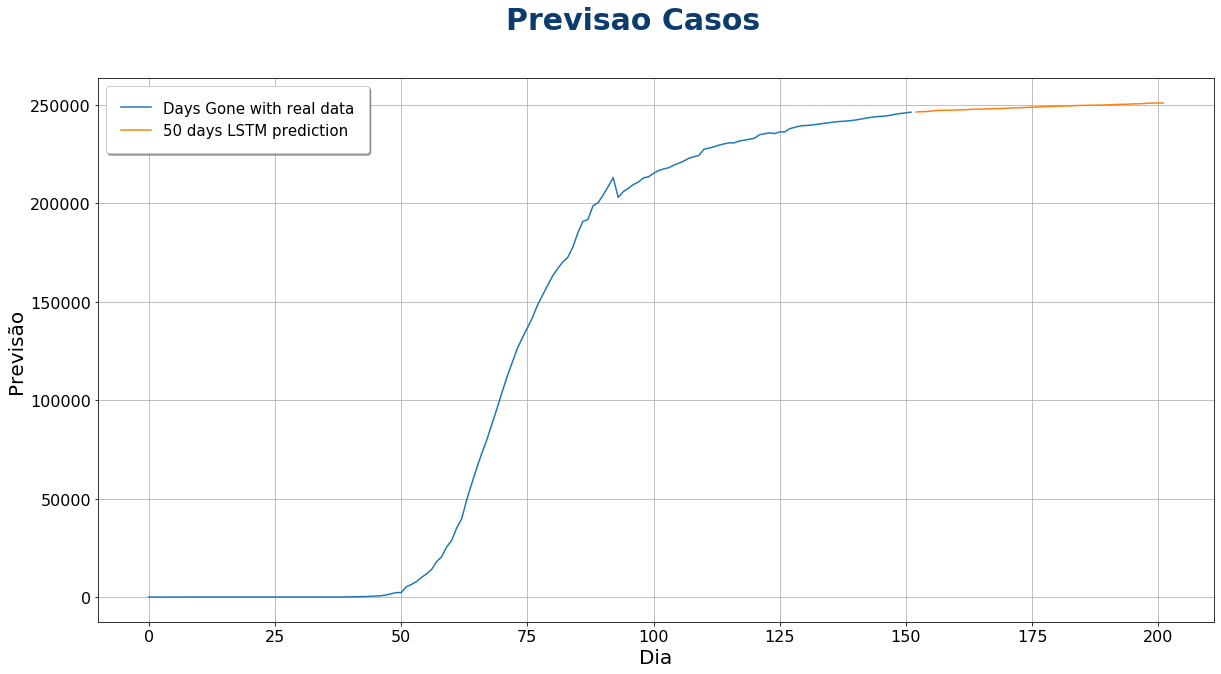

In [21]:
lstm.forecast()